## Лабораторная работа 3 - Байесовская оптимизация

## Построение регрессии с помощью Гауссовского процесса

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbs

### Генерация выборки

Ответ на очередном объекте $x_i$ генерируется следующим образом:

$$t_i = f(x_i)+\varepsilon_i, \; \varepsilon_i \sim \mathcal{N}(0,\sqrt{2})$$

In [3]:
def f(x):
    return -8*np.sin(x)

support = np.arange(-1.0, 11.0, 1e-2)

In [4]:
X_train = np.arange(0,10.0,0.5)
X_train = X_train.reshape([len(X_train), -1])
Y_train = f(X_train)
T_train = Y_train+2*np.random.randn(*X_train.shape)

X_test = support
X_test = X_test.reshape([len(X_test), -1])

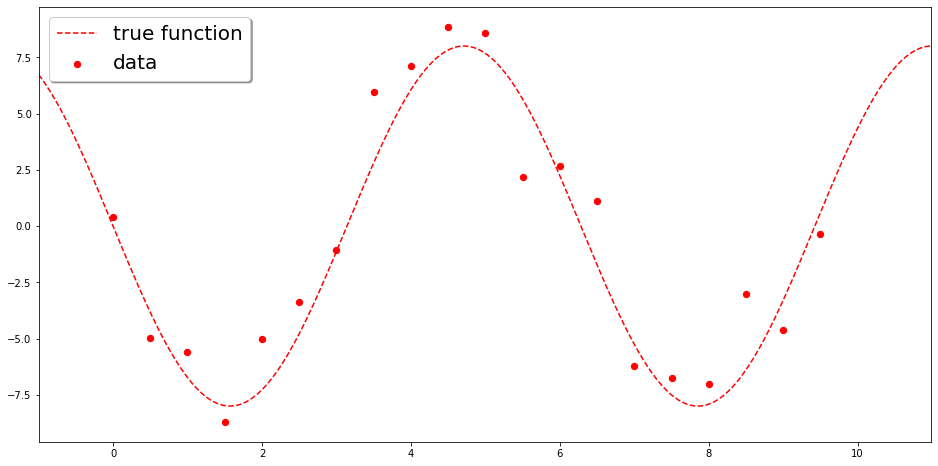

In [5]:
plt.figure(figsize=(16,8))
plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
plt.plot(support, f(support), '--r', label='true function')
plt.legend(fontsize=20, frameon=True, shadow=True)
plt.xlim(np.min(support), np.max(support))
plt.show()

### Предсказание

В тестовой точке $x$ мы можем предсказать два параметра – мат. ожидание $\mu(x)$ и стандартное отклонение $\sigma(x)$.
Для заданной ковариационной функции $k(x,y)$ и для заданной дисперсии случайного шума $\beta^{-1}$, $\mu(x), \sigma(x)$ вычисляются по следующим формулам:

$$\mu(x) = \mathbf{k}^TC_N^{-1}\mathbf{t}, \;\;\;\; \sigma^2(x) = k(x,x)+\beta^{-1}-\mathbf{k}^TC_N^{-1}\mathbf{k},$$

где $\mathbf{k} = k(x_i, x)$ – вектор, состоящий из элементов $k(x_i, x), \; i=1,\ldots,N$,  
$\mathbf{t} = (t_1,\ldots,t_N)$ – вектор ответов на обучающей выборке,  
$С_N = \mathbf{K} + \beta^{-1}E$, где $\mathbf{K}_{ij} = k(x_i,x_j)$ – ковариационная матрица.

Примеры ковариационных функций:
- $K(x,y) = C$ – константная,
- $K(x,y) = \sum_{j=1}^d\theta_jx_jy_j$ – линейная,
- $K(x,y) = \exp(-\sum_{j=1}^d\theta_j(x_j-y_j)^2)$  – экспоненциальная,
- $K(x,y) = \exp(-\sum_{j=1}^d\theta_j|x_j-y_j|)$ – процесс Орнштейна-Уленбека.

**1.** Реализуте функции вычисления ковариационных матриц между двумя произвольными выборками объектов, а затем функцию, вычисляющую предсказание в новой точке. Циклы использовать запрещено.

In [6]:
def linear_k(X, Y, theta):
    return (theta * X).dot(Y.T)
    
def rbf_k(X, Y, theta):
    distance = (X[:, np.newaxis, :] - Y) ** 2
    return np.exp(-distance.dot(theta))

def ou_k(X, Y, theta):
    distance = np.abs(X[:, np.newaxis, :] - Y)
    return np.exp(-distance.dot(theta))

def get_C(X, theta, beta, kernel):
    C = kernel(X, X, theta)
    np.fill_diagonal(C, C.diagonal() + 1 / beta)
    return C

def predict(X_train, T_train, X_test, theta, beta, kernel):
    C_train = get_C(X_train, theta, beta, kernel)
    C_inv_train = np.linalg.inv(C_train)

    C_test = get_C(X_test, theta, beta, kernel)

    K = kernel(X_train, X_test, theta)

    mu = K.T.dot(C_inv_train).dot(T_train)
    sigma = C_test - K.T.dot(C_inv_train).dot(K)
    return mu.squeeze(), np.sqrt(sigma.diagonal())

In [7]:
def plot_result():
    plt.figure(figsize=(16,8))
    plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
    plt.plot(support, f(support), '--r', label='true function')
    plt.plot(X_test, mu_test, c='b', label='mu test')
    plt.fill_between(X_test.flatten(), mu_test-sigma_test, mu_test+sigma_test, color='b', label='confidence', alpha=0.3)
    plt.legend(fontsize=20, frameon=True, shadow=True)
    plt.xlim(np.min(support), np.max(support))

### Экспоненциальная ковариационная функция

In [8]:
theta = np.array([1.0])
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

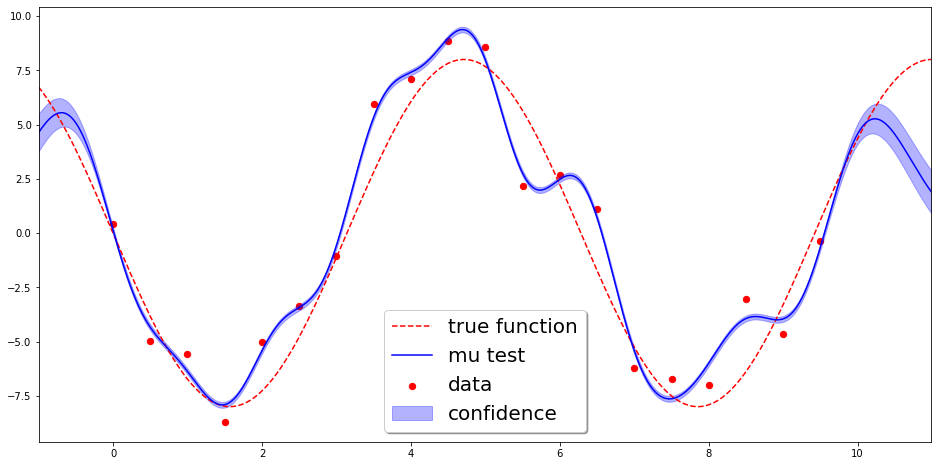

In [9]:
plot_result()

Посмотрим как ведёт себя регрессия для разных значений $\beta$

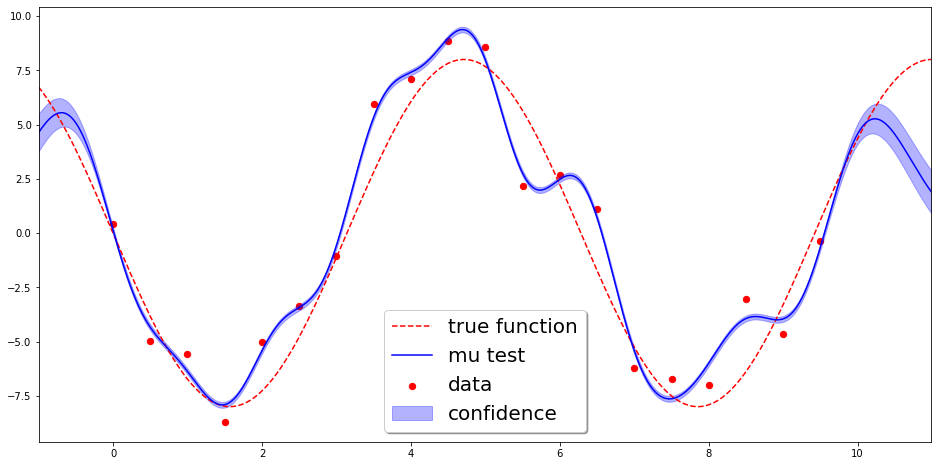

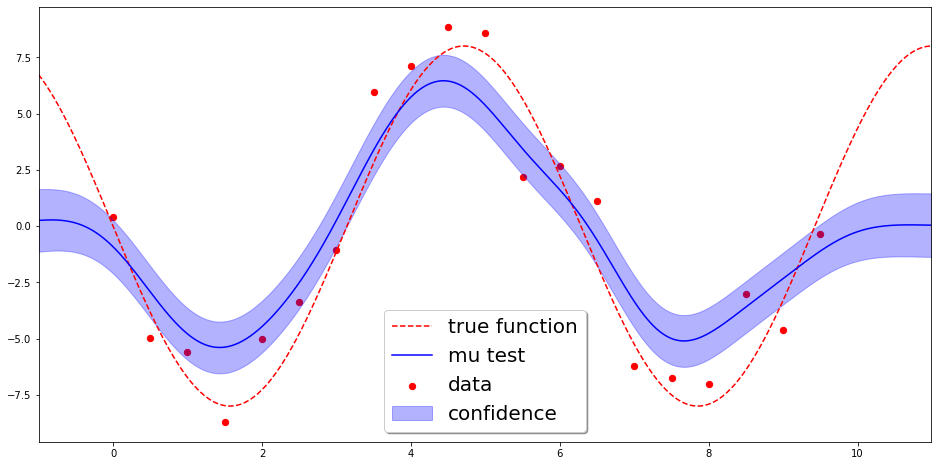

In [10]:
theta = np.array([1.0])
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)
mu_test = mu_test.squeeze()
plot_result()
plt.show()

theta = np.array([1.0])
beta = 1.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)
plot_result()
plt.show()

Запишите что вы пронаблюдали и как можно интерпретировать параметр $\beta$.  

При меньшем $\beta^{-1}$ больше подгоняемся под конкретные точки

Доверительный интервал для некоторого уровня значимости по формуле включается в себя дисперсия шума, поэтому чем выше дисперсия шума, тем шире доверительный интервал.

### Линейная ковариационная функция

In [11]:
theta = np.array([1.0])
beta = 100.0
kernel = linear_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

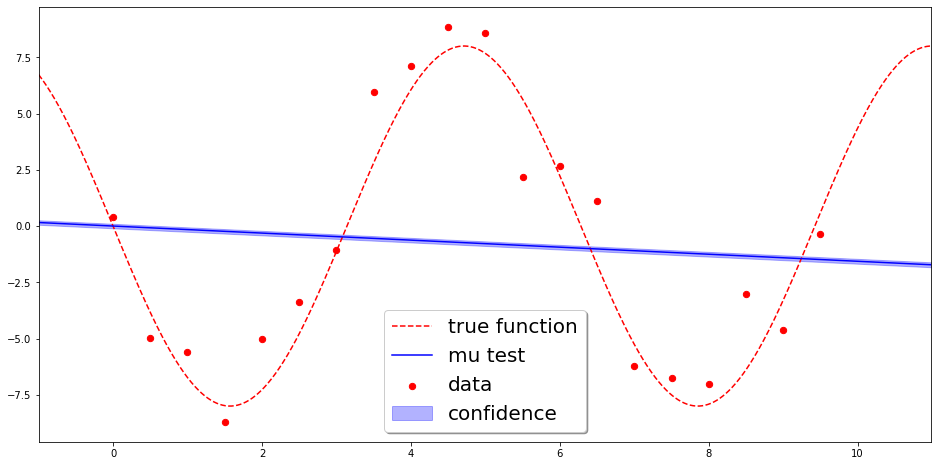

In [12]:
plot_result()

### Ковариационная функция Орнштейна-Уленбека

In [13]:
theta = np.array([1.0])
beta = 100.0
kernel = ou_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

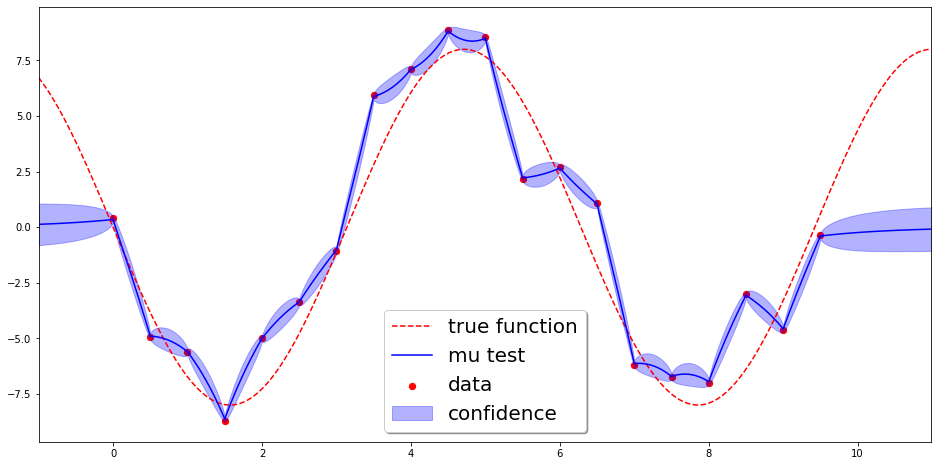

In [14]:
plot_result()

На практике часто прибегают к смеси ковариационных функций, чтобы добиться определённых свойств регрессии.

In [15]:
theta = np.array([1.0])
beta = 10.0
kernel = lambda X,Y,theta: ou_k(X,Y,theta) + rbf_k(X,Y,theta)
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

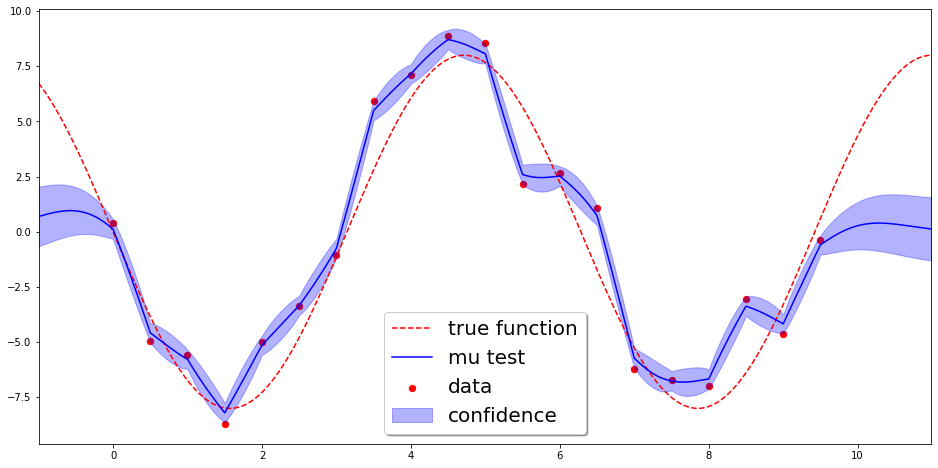

In [16]:
plot_result()

### Подбор параметров

Подбор параметров $\theta$ для произвольного ядра можно сделать максимизируя логарифм правдоподобия на обучающей выборке:

$$\log p(\mathbf{t}|\theta) = -\frac{1}{2}\log|C_N| - \frac{1}{2}\mathbf{t}^TC_N^{-1}\mathbf{t} - \frac{N}{2}\log(2\pi) \to \max_{\theta}.$$

Максимизировать заданный функционал мы будем с помощью градиентного подъёма. Однако, мы будем проводить оптимизацию по $\log\theta$ (т.е. считать градиенты относительно $\log\theta$ и обновлять $\log\theta$, а не сами $\theta$), поскольку так процесс проще сходится

Вам пригодится формула для градиента по $\theta$:

$$\frac{\partial}{\partial \theta_j}\log p(\mathbf{t}|\theta) = -\frac{1}{2}\text{Tr}\bigg(C_N^{-1}\frac{\partial C_N}{\partial \theta_j}\bigg) + \frac{1}{2}\mathbf{t}^TC_N^{-1}\frac{\partial C_N}{\partial \theta_j}C_N^{-1}\mathbf{t}$$

**2.** 

  а) Получите формулу для расчёта градиента логарифма правдоподобия по $\log\theta$ 

  Надо просто домножить на $\theta$, так как $\frac{\partial}{\partial \log\theta_j}\log p(\mathbf{t}|\theta) = \frac{\partial\theta_j}{\partial\log\theta_j}\frac{\partial}{\partial \theta_j}\log p(\mathbf{t}|\theta) = \theta_j\frac{\partial}{\partial \theta_j}\log p(\mathbf{t}|\theta)$

  б) Реализуйте функцию для расчёта градиента логарифма правдоподобия по $\log\theta$ а также функцию для расчёта правдоподобия. Ядро – RBF.

In [17]:
def get_rbf_grad_log_theta(X, Y, theta, beta):
    K = rbf_k(X, X, theta)
    C = K + np.eye(X.shape[0]) / beta
    C_inv = np.linalg.inv(C)

    grad_C = -K[np.newaxis, :, :] * ((X[:, np.newaxis, :] - X) ** 2).T
    temp = grad_C.dot(C_inv)

    first = -temp.diagonal(axis1=1, axis2=2).sum(axis=1)
    second = Y.T.dot(C_inv).dot(temp).dot(Y).squeeze()

    return 0.5 * (first + second) * theta

def get_log_likelihood(X, Y, theta, beta):
    N = X.shape[0]
    C = get_C(X, theta, beta, rbf_k)
    C_inv = np.linalg.inv(C)

    log_p = np.log(np.linalg.det(C)) + Y.T.dot(C_inv).dot(Y) + N * np.log(2 * np.pi)

    return -0.5 * log_p

In [18]:
lr = 1e-3
num_iterations = 100
beta = 100.0
log_theta = np.log(np.array([10.0]))
log_likelihood = np.zeros(num_iterations)
theta_history = np.zeros(num_iterations)
for i in range(num_iterations):
    theta_history[i] = np.exp(log_theta)
    log_theta = log_theta + lr*get_rbf_grad_log_theta(X_train, T_train, np.exp(log_theta), beta)
    log_likelihood[i] = get_log_likelihood(X_train, T_train, np.exp(log_theta), beta)

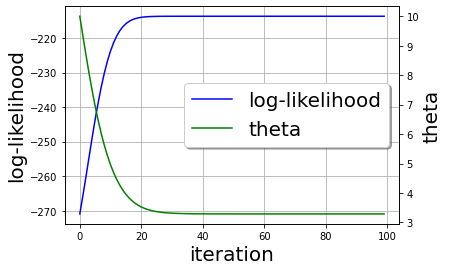

In [19]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(log_likelihood, label='log-likelihood', c='b')
ax1.set_xlabel('iteration', fontsize=20)
ax1.set_ylabel('log-likelihood', fontsize=20)
ax1.grid()

ax2.plot(theta_history, label='theta', c='g')
ax2.set_ylabel('theta', fontsize=20)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, fontsize=20, loc='center right', frameon=True, shadow=True)
plt.show()

In [20]:
beta = 100.0
kernel = rbf_k
theta = np.exp(log_theta)
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

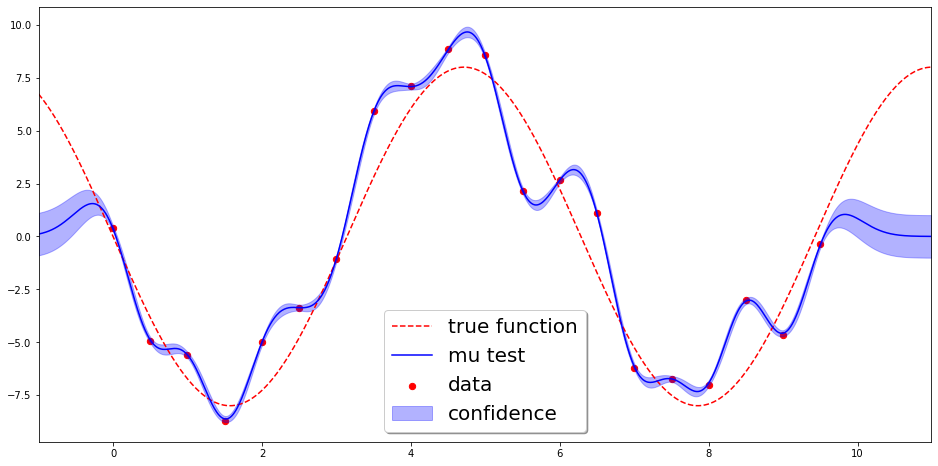

In [21]:
plot_result()

In [22]:
theta

array([3.28832919])

Сравните этот график с графиком для $\theta=1$. Что произошло с мат. ожиданием? Как изменился параметр $\theta$?

Функция мат. ожидания теперь проходит через все точки обучающего множества. 

$\theta$ увеличилось


## Оптимизация с помощью Гауссовского процесса

С помощью Гауссовского процесса можно решать задачи black-box оптимизации. То есть, оптимизировать функцию, вид которой нам не известен и нет никакой дополнительной информации, кроме её значений в некоторых точках. Такой метод оптимизации может использоваться для поиска экстремумов некоторой функции, которую очень дорого вычислять, а градиенты этой функции мы и вовсе не можем рассчитать.

Концепция такого алгоритма оптимизации следующая:
1. Настраиваем параметры Гауссовского процесса для имеющегося набора точек.
2. В каждой точке пространства $x$ мы можем посчитать величину expected improvement:
$$\text{EI}(x) = \mathbb{E}_{y(x)}\max(0,t_{\min} - y(x)),$$
где $t_{\min}$ – минимальное значение целевой переменной на уже имеющейся выборке.  
На практике же, мы не можем посчитать expected improvement в каждой точке пространства, но мы можем оптимизировать эту функцию относительно $x$ методами первого или второго порядка и найти локальный максимум этой функции.
3. В качестве новой точки выбираем $x^* = \text{argmax}\; \text{EI}(x)$ и рассчитываем значение $t^*$ в этой точке. После чего добавляем эту точку к нашим данным и возвращаемся к шагу 1.

Сгенерируем выборку

In [23]:
def f(x):
    return -1/np.sqrt(2*np.pi*0.25)*np.exp(-0.5/0.09*(x-4)**2)-1/np.sqrt(2*np.pi*1.0)*np.exp(-0.5/1.0*(x-8)**2)

support = np.arange(0.95,11.1,1e-2)

In [24]:
X_train = np.arange(2.0,10.0,3.0)
X_train = X_train + (2.*np.random.rand(len(X_train))-1.)
X_train = X_train.reshape([len(X_train), -1])
Y_train = f(X_train)
T_train = Y_train

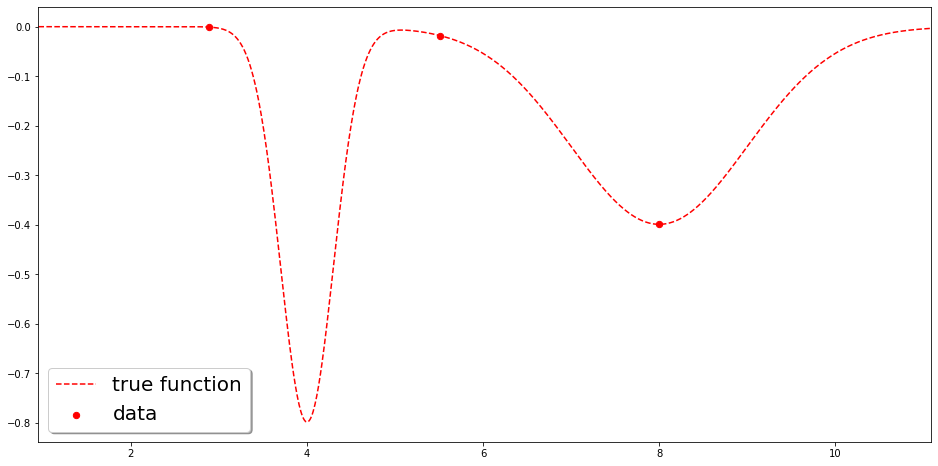

In [25]:
plt.figure(figsize=(16,8))
plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
plt.plot(support, f(support), '--r', label='true function')
plt.legend(fontsize=20, frameon=True, shadow=True)
plt.xlim(np.min(support), np.max(support))
plt.show()

**3.** Выведите формулу для expected improvement.

$$
EI(x) = \mathbb{E}_{y(x)}\max(0, y_{\min} - y(x)) = \int\limits_{-\infty}^{y_{\min}} (y_{\min} - y) \mathcal{N} (y|\mu, \sigma^2) dy = 
$$
$$
=y_{\min}\int\limits_{-\infty}^{y_{\min}}\mathcal{N} (y|\mu, \sigma^2) dy - \int\limits_{-\infty}^{\mu} y\mathcal{N} (y|\mu, \sigma^2) dy - \int\limits_{\mu}^{y_{\min}} y \mathcal{N} (y|\mu, \sigma^2) dy
$$
$$
=y_{\min}\int\limits_{-\infty}^{\frac{y_{\min}-\mu}{\sigma}}\mathcal{N} (t|0, 1) dt - \int\limits_{-\infty}^{0} (t+\mu)\mathcal{N} (t|0, \sigma^2) dt - \int\limits_{0}^{y_{\min}-\mu}(t+\mu) \mathcal{N} (t|0, \sigma^2) dt
$$
$$
=y_{\min}\int\limits_{-\infty}^{\frac{y_{\min}-\mu}{\sigma}}\mathcal{N} (t|0, 1) dt - \mu\int\limits_{-\infty}^{y_{\min}-\mu}\mathcal{N} (t|0, \sigma^2) dt - \int\limits_{-\infty}^{y_{\min}-\mu}t\mathcal{N} (t|0, \sigma^2) dt
$$
$$
=(y_{\min} - \mu)\int\limits_{-\infty}^{\frac{y_{\min}-\mu}{\sigma}}\mathcal{N} (t|0, 1) dt - \sigma\int\limits_{-\infty}^{\frac{y_{\min}-\mu}{\sigma}}t\mathcal{N} (t|0, 1) dt
$$
$$
= (y_{\min} - \mu) \Phi\left(\frac{y_{\min}  - \mu}{\sigma}\right) + \frac{\sigma}{\sqrt{2\pi}}\exp\left(-\frac{t^2}{2}\right)|^{\frac{y_{\min}-\mu}{\sigma}}_{-\infty}
$$
$$
= (y_{\min} - \mu) \Phi\left(\frac{y_{\min}  - \mu}{\sigma}\right) + \sigma N(\frac{y_{\min} - \mu}{\sigma}|, 0, 1)
$$

**4.** Реализуйте функцию для расчёта expected improvement.

In [26]:
from scipy import stats

def get_expected_improvement(X_train, T_train, X_test, theta, beta, kernel):
    mu, sigma = predict(X_train, T_train, X_test, theta, beta, kernel)
    diff = T_train.min() - mu

    return diff * stats.norm.cdf(diff / sigma) + sigma * stats.norm.cdf(diff / sigma)

In [27]:
X_test = support
X_test = X_test.reshape([len(X_test), -1])

In [28]:
def plot_expected_improvement(X_train, T_train, expected_improvement, predictions, sigma):
    fig, ax1 = plt.subplots(1,1)
    ax2 = ax1.twinx()

    ax1.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
    ax1.plot(support, predictions, label='mean')
    ax1.fill_between(support, predictions-sigma, predictions+sigma, color='b', alpha=0.3, label='uncertainty')
    ax1.plot(support, f(support), '--r', label='true function')
    ax1.grid()

    ax2.plot(support, expected_improvement, label='Expected improvement', c='g')
    ax2.scatter(support[np.argmax(expected_improvement)], np.max(expected_improvement), label='max', c='g', s=40)
    ax2.set_ylabel('Expected improvement', fontsize=20)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, fontsize=10, frameon=True, shadow=True)
    plt.xlim(np.min(support), np.max(support))

In [29]:
import time
from IPython import display

Запустите процесс оптимизации. Сошёлся ли он в точку минимума? Попробуйте разные значения параметров.  

Сошелся

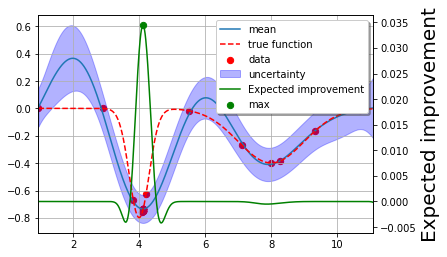

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [30]:
beta = 100.0
num_tuning_steps = 500
num_new_points = 30
lr = 1e-2
for _ in range(num_new_points):
    plt.clf()
    # model tuning
    log_theta = np.log(np.array([10.0]))
    for _ in range(num_tuning_steps):
        grad = get_rbf_grad_log_theta(X_train, T_train, np.exp(log_theta), beta)
        log_theta = log_theta + lr*grad
    # calculating expected improvement for all points
    expected_improvement = get_expected_improvement(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)
    mu, sigma = predict(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)
    plot_expected_improvement(X_train, T_train, expected_improvement, mu, sigma)
    # adding new point
    X_train = np.vstack([X_train, np.array(support[np.argmax(expected_improvement)])])
    T_train = f(X_train)

    display.clear_output(wait=True)
    display.display(plt.gcf())

_ = plt.clf()